# Pulsar Star KNN Classification Model

## Introduction

[Insert Paragraph]

## Preliminary exploratory data analysis

Loading in libaries.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Reading

Reading the pulsar star dataset from the web.

In [2]:
pulsar_data <- read_csv("https://raw.githubusercontent.com/rchanpra/dsci100_group_project/main/HTRU2/HTRU_2.csv", col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Wrangling

Adding column names to the dataset.

In [3]:
colnames(pulsar_data) <- c("mean_profile",
                           "deviation_profile",
                           "kurtosis_profile",
                           "skewness_profile",
                           "mean_dmsnr",
                           "deviation_dmsnr",
                           "kurtosis_dmsnr",
                           "skewness_dmsnr",
                           "class")

Renaming values inside the *class* variable from 1 to *"pulsar"* and 0 to *"not_pulsar"*.

In [4]:
pulsar_data <- pulsar_data |>
    mutate(class = ifelse(class == 1, "pulsar", "not_pulsar"))

Factoring the *class* variable.

In [5]:
pulsar_data <- pulsar_data |>
    mutate(class = as_factor(class))

The pulsar star dataset is now tidy.

In [6]:
pulsar_data

mean_profile,deviation_profile,kurtosis_profile,skewness_profile,mean_dmsnr,deviation_dmsnr,kurtosis_dmsnr,skewness_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,not_pulsar
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,not_pulsar
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,not_pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,not_pulsar
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,not_pulsar
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,not_pulsar


### Splitting

Splitting into the dataset into training and testing data.

In [7]:
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

### Summarizing

The number of rows that has missing data:

In [8]:
pulsar_train |> is.na() |> sum()

[1] 0

The means of the variables:

In [9]:
pulsar_train |> summary()

  mean_profile     deviation_profile kurtosis_profile   skewness_profile 
 Min.   :  5.812   Min.   :24.77     Min.   :-1.87601   Min.   :-1.7919  
 1st Qu.:101.098   1st Qu.:42.39     1st Qu.: 0.02526   1st Qu.:-0.1845  
 Median :115.047   Median :46.98     Median : 0.22295   Median : 0.1981  
 Mean   :111.270   Mean   :46.54     Mean   : 0.46843   Mean   : 1.7310  
 3rd Qu.:127.094   3rd Qu.:50.99     3rd Qu.: 0.46887   3rd Qu.: 0.9192  
 Max.   :192.617   Max.   :91.81     Max.   : 8.06952   Max.   :68.1016  
   mean_dmsnr       deviation_dmsnr  kurtosis_dmsnr   skewness_dmsnr    
 Min.   :  0.2132   Min.   :  7.37   Min.   :-3.139   Min.   :  -1.977  
 1st Qu.:  1.9289   1st Qu.: 14.44   1st Qu.: 5.787   1st Qu.:  35.078  
 Median :  2.8010   Median : 18.43   Median : 8.437   Median :  83.126  
 Mean   : 12.4322   Mean   : 26.21   Mean   : 8.317   Mean   : 105.007  
 3rd Qu.:  5.4666   3rd Qu.: 28.34   3rd Qu.:10.705   3rd Qu.: 138.946  
 Max.   :223.3921   Max.   :110.64   Max.   

In the training data, the total number of observations is 13423, of which 1206 is pulsar and 12217 is not pulsar.

### Visualizing

Creating violin plots to determine the best variables to be used as predictors.

In [10]:
mean_profile_plot <- pulsar_train |>
        ggplot(aes(x = class, y = mean_profile, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$mean_profile), linetype = "dashed") +
        labs(x = "Class", y = "Mean of the integrated profile", fill = "Class") +
        theme(text = element_text(size = 15))

deviation_profile_plot <- pulsar_train |>
        ggplot(aes(x = class, y = deviation_profile, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$deviation_profile), linetype = "dashed") +
        labs(x = "Class", y = "Standard deviation of the integrated profile", fill = "Class") +
        theme(text = element_text(size = 15))

kurtosis_profile_plot <- pulsar_train |>
        ggplot(aes(x = class, y = kurtosis_profile, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$kurtosis_profile), linetype = "dashed") +
        labs(x = "Class", y = "Excess kurtosis of the integrated profile", fill = "Class") +
        theme(text = element_text(size = 15))

skewness_profile_plot <- pulsar_train |>
        ggplot(aes(x = class, y = skewness_profile, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$skewness_profile), linetype = "dashed") +
        labs(x = "Class", y = "Skewness of the integrated profile", fill = "Class") +
        theme(text = element_text(size = 15))

mean_dmsnr_plot <- pulsar_train |>
        ggplot(aes(x = class, y = mean_dmsnr, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$mean_dmsnr), linetype = "dashed") +
        labs(x = "Class", y = "Mean of the DM-SNR curve", fill = "Class") +
        theme(text = element_text(size = 15))

deviation_dmsnr_plot <- pulsar_train |>
        ggplot(aes(x = class, y = deviation_dmsnr, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$deviation_dmsnr), linetype = "dashed") +
        labs(x = "Class", y = "Standard deviation of the DM-SNR curve", fill = "Class") +
        theme(text = element_text(size = 15))

kurtosis_dmsnr_plot <- pulsar_train |>
        ggplot(aes(x = class, y = kurtosis_dmsnr, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$kurtosis_dmsnr), linetype = "dashed") +
        labs(x = "Class", y = "Excess kurtosis of the DM-SNR curve", fill = "Class") +
        theme(text = element_text(size = 15))

skewness_dmsnr_plot <- pulsar_train |>
        ggplot(aes(x = class, y = skewness_dmsnr, fill = class)) +
        geom_violin() +
        geom_boxplot(width = 0.1, alpha = 0.5) +
        geom_hline(yintercept = mean(pulsar_train$skewness_dmsnr), linetype = "dashed") +
        labs(x = "Class", y = "Skewness of the DM-SNR curve", fill = "Class") +
        theme(text = element_text(size = 15))

Plotting the combined violin plots.

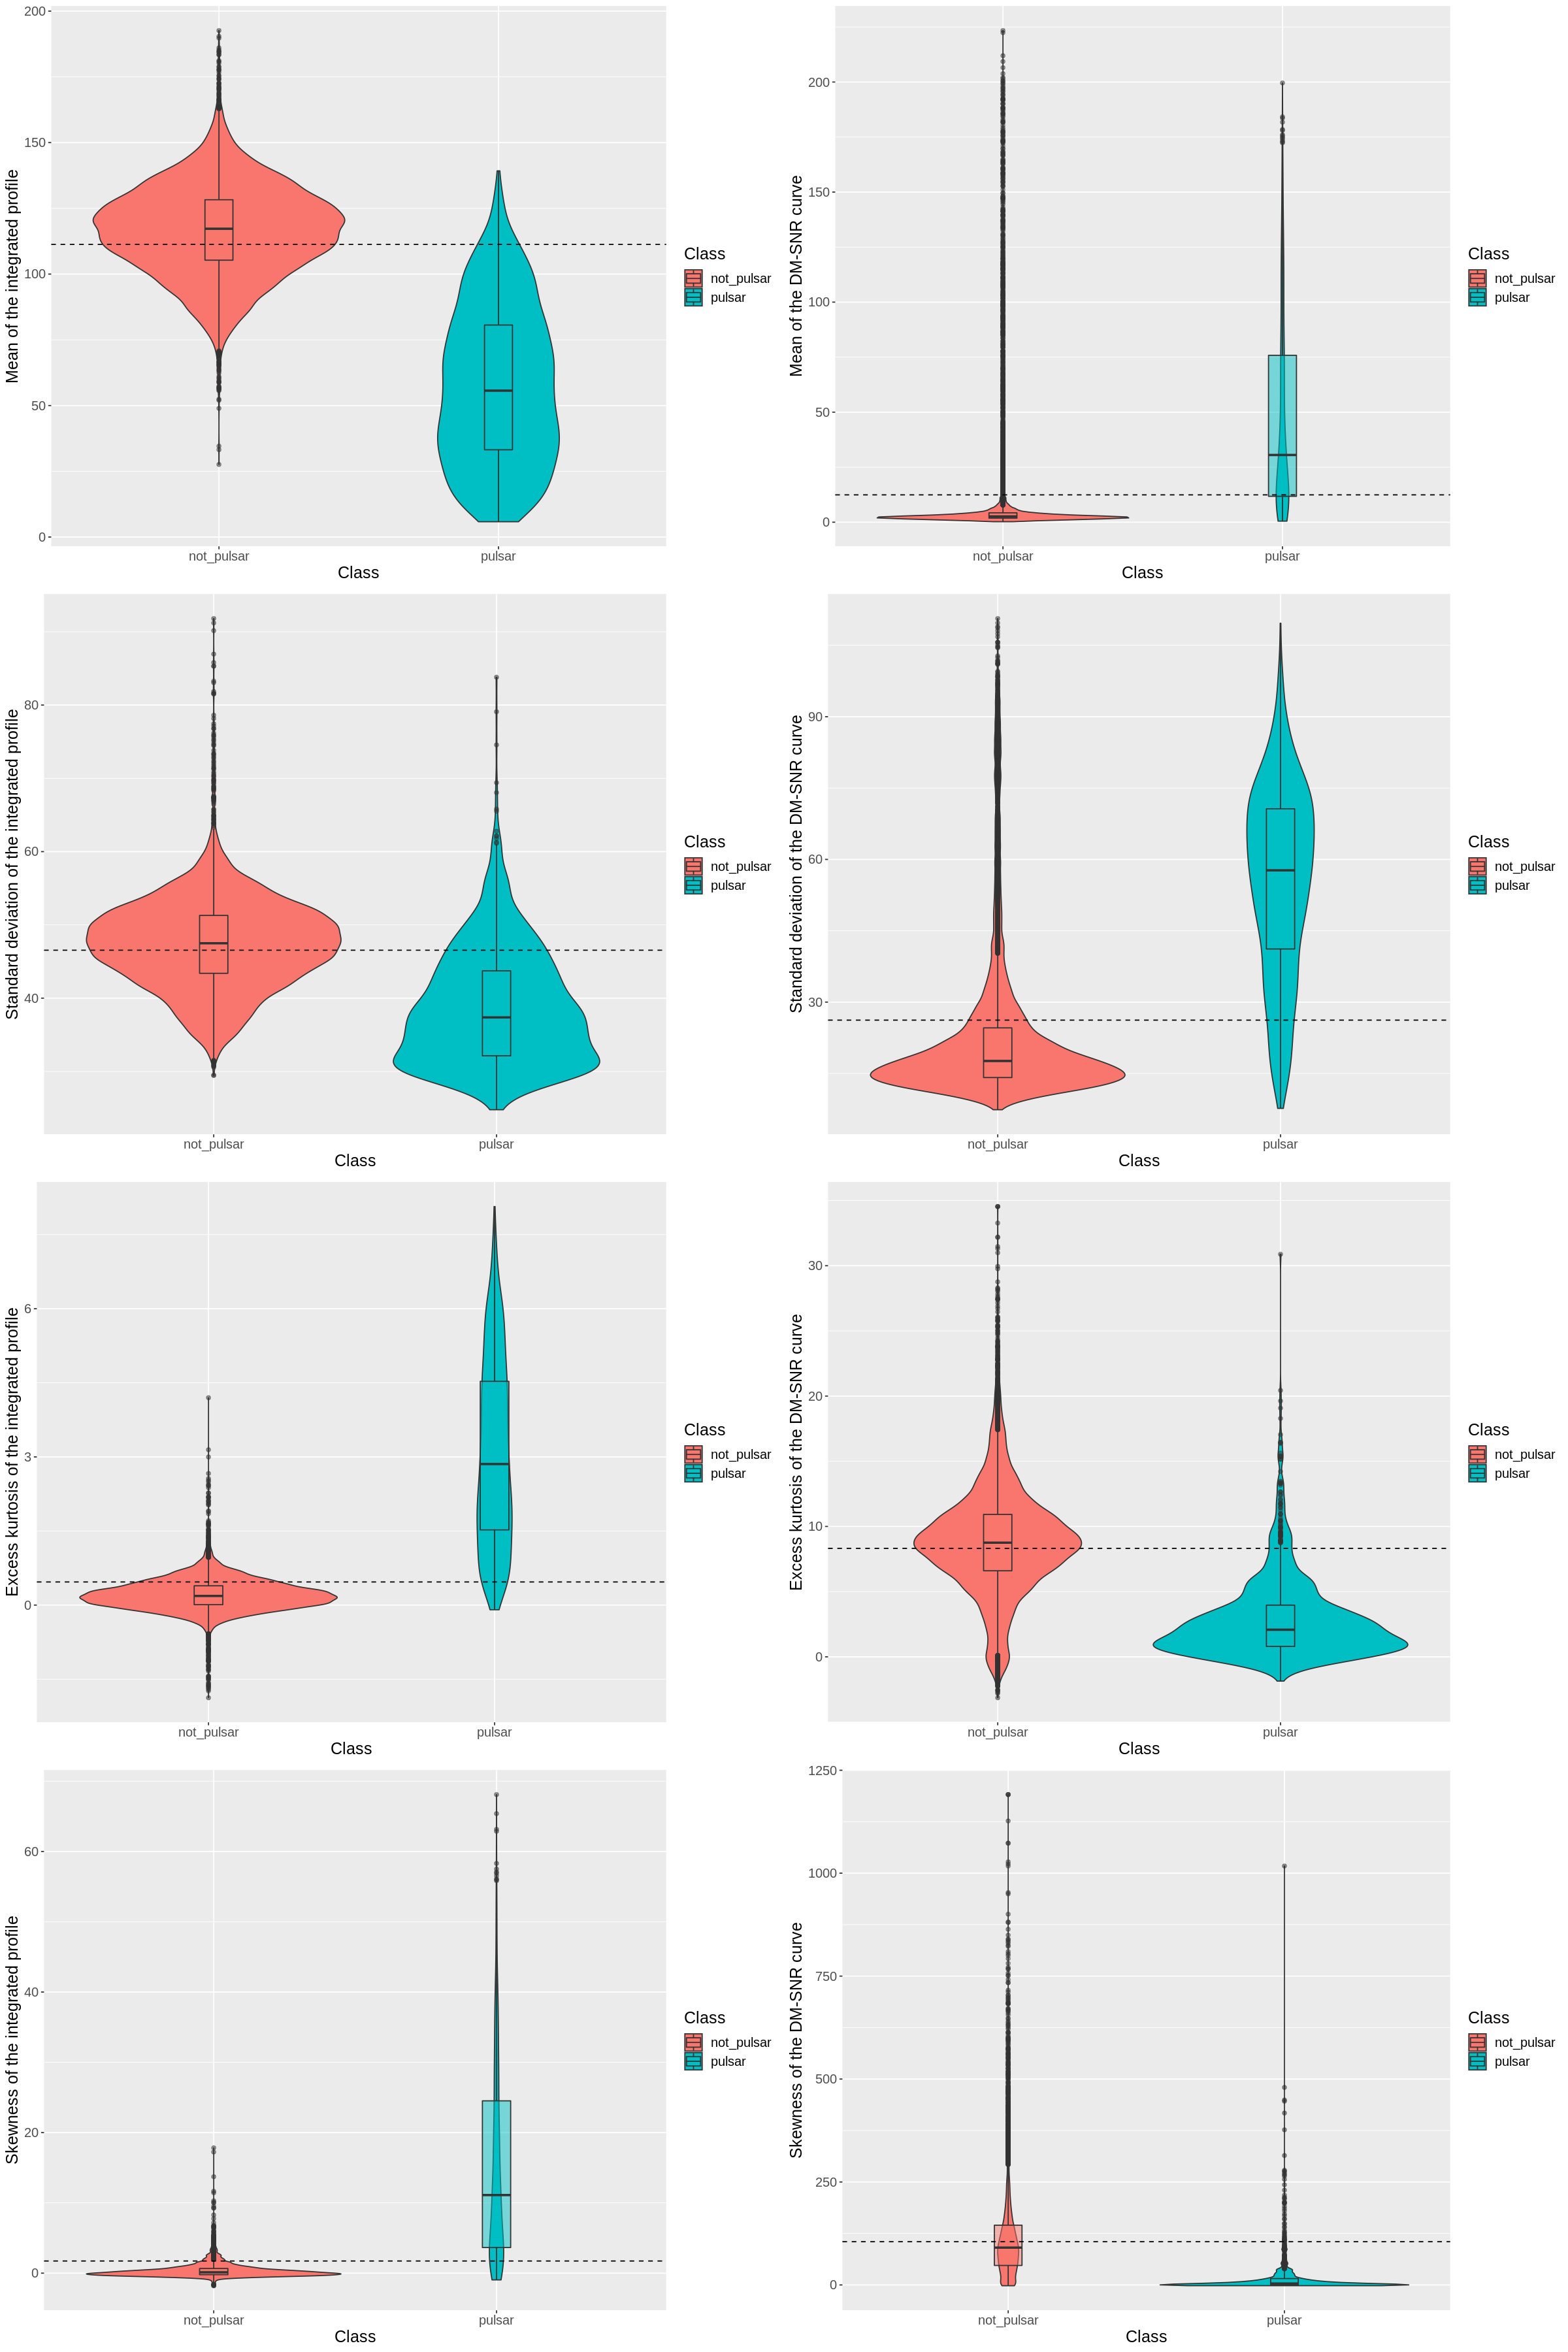

In [11]:
options(repr.plot.width = 20, repr.plot.height = 30)

plot_grid(mean_profile_plot,
          mean_dmsnr_plot,
          deviation_profile_plot,
          deviation_dmsnr_plot,
          kurtosis_profile_plot,
          kurtosis_dmsnr_plot,
          skewness_profile_plot,
          skewness_dmsnr_plot,
          ncol = 2)

## Methods

From the violin plots, we will use the following 4 variables:
- Mean of the integrated profile
- Excess kurtosis of the integrated profile
- Skewness of the integrated profile
- Excess kurtosis of the DM-SNR curve

We will use the k-nearest neighbors algorithm to build the classification model. We will tune and cross-validate to find the best representation of the accuracy of each K and determine the best value of K to use for the model. We will then build the model by training and testing it with the best value of K obtained.

We are planning to visualize the results of the model by utilizing a scatter plot that is coloured with the correctness of the model for each observation.. This will come with an accuracy percentage of the model.

## Expected outcomes and significance

[Insert Paragraph]